# Interpreter

This notebook contains the metrics for both models and provides a way to interact with each via GUI (do note that the predicition time can last several minutes).

Simply "Runtime" -> "Run all" to use!

# Imports and installs

In [1]:
!pip install ipywidgets
!pip install datasets
!pip install transformers[sentencepiece]
!pip install tokenizers
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from ipywidgets import interact
import plotly.express as px
import dash
from dash import Dash, dcc, html, Input, Output
from itertools import cycle
from random import shuffle
from plotly.validators.scatter.marker import SymbolValidator
from plotly.validators.scatter.line import DashValidator
%matplotlib inline

# Model metrics

In [4]:
songs_loaded = [500, 1000, 1500, 2000, 2500, 3000]

pegasus_dict = {
    "songs loaded" : songs_loaded,
    "p-rouge1-r" :  [0.01020408163265306,  0.018518518518518517, 0.028722600151171576, 0.07086167800453515, 0.07086167800453515, 0.11407155454774502],
    "p-rouge1-p" : [0.2, 0.25, 0.3875, 0.4825174825174825, 0.4343891402714932, 0.2933634992458522],
    "p-rouge1-f" : [0.01941747526628335, 0.03448275797859692, 0.05312533961674416, 0.12326761453183363, 0.12183163492135196, 0.1594202864015872],
    "p-rouge2-r" : [0.0, 0.004166666666666667, 0.004166666666666667, 0.020833333333333332,  0.020833333333333332, 0.025],
    "p-rouge2-p" : [0.0, 0.08333333333333333, 0.0625, 0.16666666666666666, 0.17857142857142858, 0.06976744186046512],
    "p-rouge2-f": [0.0, 0.007936507482993222, 0.007812499414062544, 0.03703703604938274, 0.03731343190020051, 0.036809814008807354],
    "p-rougeL-r": [0.01020408163265306, 0.018518518518518517, 0.028722600151171576, 0.06575963718820861, 0.06468883849836231, 0.10789871504157218],
    "p-rougeL-p": [0.2, 0.25, 0.3875, 0.4370629370629371, 0.3959276018099548, 0.28054298642533937],
    "p-rougeL-f": [0.01941747526628335, 0.03448275797859692, 0.05312533961674416, 0.11409330260522814, 0.11119333704901155, 0.15108695306825387],
    "p-meteor" : [0.05859221777673178, 0.0689278174323916, 0.09982092084754013, 0.10804279255366213, 0.11153267947247295, 0.18277770549823882],
    "p-BERTScore-r": [0.7319, 0.7673, 0.7949, 0.8073, 0.8052, 0.8404],
    "p-BERTScore-p": [0.7736, 0.7770, 0.7947, 0.8105, 0.8125, 0.8208],
    "p-BERTScore-f": [0.7522, 0.7721, 0.7948, 0.8089, 0.8088, 0.8305]
    }

bert_dict = {
        "b-rouge1-r": [0.14978584026203073, 0.1283068783068783, 0.18764172335600907, 0.1599899218946838, 0.17126480221718315, 0.17743764172335602],
        "b-rouge1-p": [0.40714285714285714, 0.30030959752321984, 0.4291497975708502, 0.4285714285714286,  0.4328547297297297, 0.4225563909774436],
        "b-rouge1-f": [0.21729611001257618, 0.17908071911249016, 0.2607495510866594, 0.23168103058145825, 0.2440677926021495, 0.24900486099130287],
        "b-rouge2-r": [0.03205128205128205, 0.029166666666666667, 0.03685897435897436, 0.04455128205128205, 0.04871794871794872, 0.04455128205128205],
        "b-rouge2-p": [0.09017223910840932, 0.07, 0.09040816326530612, 0.11956521739130435, 0.13041314086610253, 0.11736111111111111],
        "b-rouge2-f": [0.04720790589397701, 0.041176468512110834, 0.05234965088157531, 0.06489594349234781, 0.07072908709047165, 0.06452380557278939],
        "b-rougeL-r": [0.1436130007558579, 0.1283068783068783, 0.1599899218946838, 0.15381708238851094, 0.17126480221718315, 0.17126480221718315],
        "b-rougeL-p": [0.39285714285714285, 0.30030959752321984, 0.3643724696356275, 0.41428571428571426, 0.4328547297297297, 0.40939849624060154],
        "b-rougeL-f": [ 0.20867542035740375, 0.17908071911249016, 0.2220450181786057, 0.22306034092628582, 0.2440677926021495, 0.24060149964676505],
        "b-meteor" : [0.26145411346736447, 0.23785767209540679, 0.2875325940215777, 0.26823947764628797, 0.2764248119116917, 0.28509573388607945],
        "b-BERTScore-r": [0.8574, 0.8598, 0.8537, 0.8675, 0.8539, 0.8596],
        "b-BERTScore-p": [0.8222, 0.8236, 0.8230, 0.8298, 0.8249, 0.8255],
        "b-BERTScore-f": [0.8394, 0.8413, 0.8381, 0.8482, 0.8392, 0.8422]
        }

pegasus_df = pd.DataFrame.from_dict(pegasus_dict)
bert_df = pd.DataFrame.from_dict(bert_dict)

df = pd.concat([pegasus_df, bert_df], axis=1, join='inner')

df

,songs loaded,p-rouge1-r,p-rouge1-p,p-rouge1-f,p-rouge2-r,p-rouge2-p,p-rouge2-f,p-rougeL-r,p-rougeL-p,p-rougeL-f,...,b-rouge2-r,b-rouge2-p,b-rouge2-f,b-rougeL-r,b-rougeL-p,b-rougeL-f,b-meteor,b-BERTScore-r,b-BERTScore-p,b-BERTScore-f
0,500,0.010204,0.200000,0.019417,0.000000,0.000000,0.000000,0.010204,0.200000,0.019417,...,0.032051,0.090172,0.047208,0.143613,0.392857,0.208675,0.261454,0.8574,0.8222,0.8394
1,1000,0.018519,0.250000,0.034483,0.004167,0.083333,0.007937,0.018519,0.250000,0.034483,...,0.029167,0.070000,0.041176,0.128307,0.300310,0.179081,0.237858,0.8598,0.8236,0.8413
2,1500,0.028723,0.387500,0.053125,0.004167,0.062500,0.007812,0.028723,0.387500,0.053125,...,0.036859,0.090408,0.052350,0.159990,0.364372,0.222045,0.287533,0.8537,0.8230,0.8381
3,2000,0.070862,0.482517,0.123268,0.020833,0.166667,0.037037,0.065760,0.437063,0.114093,...,0.044551,0.119565,0.064896,0.153817,0.414286,0.223060,0.268239,0.8675,0.8298,0.8482
4,2500,0.070862,0.434389,0.121832,0.020833,0.178571,0.037313,0.064689,0.395928,0.111193,...,0.048718,0.130413,0.070729,0.171265,0.432855,0.244068,0.276425,0.8539,0.8249,0.8392
5,3000,0.114072,0.293363,0.159420,0.025000,0.069767,0.036810,0.107899,0.280543,0.151087,...,0.044551,0.117361,0.064524,0.171265,0.409398,0.240601,0.285096,0.8596,0.8255,0.8422


In [5]:

# Create Dash app
model_app = dash.Dash(__name__)

model_app.layout = html.Div([
    dcc.Graph(id="graph"),

    html.Div(children=[  # Model divs

    html.Div(children=[  # PEGASUS div

    html.Label("PEGASUS"),
    html.Div(  # P R1 div
        children=
         [
            html.Label("ROUGE-1"),
            dcc.Checklist(
                id="pegasus-metrics-rouge1",
                options=[
                    {'label': "Recall", 'value': 'p-rouge1-r'},
                     {'label': "Precision", 'value': 'p-rouge1-p'},
                      {'label': "F1", 'value': 'p-rouge1-f'}],
                value=['p-rouge1-f'],
                inline=True)
          ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # P R1 div

    html.Div(  # P R2 div
        children=
         [
            html.Label("ROUGE-2"),
            dcc.Checklist(
                id="pegasus-metrics-rouge2",
                options=[
                    {'label': "Recall", 'value': 'p-rouge2-r'},
                     {'label': "Precision", 'value': 'p-rouge2-p'},
                      {'label': "F1", 'value': 'p-rouge2-f'},],
                value=['p-rouge2-f'],  # Initial PEGASUS metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # P R2 div

    html.Div(  # P RL div
        children=
         [
            html.Label("ROUGE-L"),
            dcc.Checklist(
                id="pegasus-metrics-rougeL",
                options=[
                    {'label': "Recall", 'value': 'p-rougeL-r'},
                     {'label': "Precision", 'value': 'p-rougeL-p'},
                      {'label': "F1", 'value': 'p-rougeL-f'},],
                value=['p-rougeL-f'],  # Initial PEGASUS metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # P RL div

    html.Div(  # P M div
        children=
         [
            dcc.Checklist(
                id="pegasus-metrics-meteor",
                options=[{'label': "METEOR", 'value': 'p-meteor'},],
                value=['p-meteor'],  # Initial PEGASUS metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  #P M div

    html.Div(  #P BS div
        children=[
            dcc.Checklist(
                id="pegasus-metrics-bertscore",
                options=[
                    {'label': "Recall", 'value': 'p-BERTScore-r'},
                     {'label': "Precision", 'value': 'p-BERTScore-p'},
                      {'label': "F1", 'value': 'p-BERTScore-f'}
                    ],
                value=['p-BERTScore-f'],  # Initial PEGASUS metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  #P BS div

    ],style={'padding': 10, 'flex': 1}),  # PEGASUS div

    html.Div(children=[  # BERT div

    html.Label("BERT"),
    html.Div(  # B R1 div
        children=
         [
            html.Label("ROUGE-1"),
            dcc.Checklist(
                id="bert-metrics-rouge1",
                options=[
                    {'label': "Recall", 'value': 'b-rouge1-r'},
                     {'label': "Precision", 'value': 'b-rouge1-p'},
                      {'label': "F1", 'value': 'b-rouge1-f'}],
                value=['b-rouge1-f'],
                inline=True)
          ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # B R1 div

    html.Div(  # B R2 div
        children=
         [
            html.Label("ROUGE-2"),
            dcc.Checklist(
                id="bert-metrics-rouge2",
                options=[
                    {'label': "Recall", 'value': 'b-rouge2-r'},
                     {'label': "Precision", 'value': 'b-rouge2-p'},
                      {'label': "F1", 'value': 'b-rouge2-f'},],
                value=['b-rouge2-f'],  # Initial BERT metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # B R2 div

    html.Div(  # B RL div
        children=
         [
            html.Label("ROUGE-L"),
            dcc.Checklist(
                id="bert-metrics-rougeL",
                options=[
                    {'label': "Recall", 'value': 'b-rougeL-r'},
                     {'label': "Precision", 'value': 'b-rougeL-p'},
                      {'label': "F1", 'value': 'b-rougeL-f'},],
                value=['b-rougeL-f'],  # Initial BERT metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # B RL div

    html.Div(  # B M div
        children=
         [
            dcc.Checklist(
                id="bert-metrics-meteor",
                options=[{'label': "METEOR", 'value': 'b-meteor'},],
                value=['b-meteor'],  # Initial PEGASUS metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # B M div

    html.Div(  #B BS div
        children=[
            dcc.Checklist(
                id="bert-metrics-bertscore",
                options=[
                    {'label': "Recall", 'value': 'b-BERTScore-r'},
                     {'label': "Precision", 'value': 'b-BERTScore-p'},
                      {'label': "F1", 'value': 'b-BERTScore-f'}
                    ],
                value=['b-BERTScore-f'],  # Initial PEGASUS metric selection
                inline=True)
        ],
        style={'border': '2px solid #c3c3c3', 'border-radius': '5px', 'padding': '10px'}
        ),  # B BS div

    ],style={'padding': 10, 'flex': 1}),  # BERT div

    ], style={'display': 'flex', 'flexDirection': 'row'}),

    ])  # Layout

@model_app.callback(
    Output("graph", "figure"),
    [Input("pegasus-metrics-rouge1", "value"), Input("pegasus-metrics-rouge2", "value"), Input("pegasus-metrics-rougeL", "value"), Input("pegasus-metrics-meteor", "value"), Input("pegasus-metrics-bertscore", "value"),
     Input("bert-metrics-rouge1", "value"), Input("bert-metrics-rouge2", "value"), Input("bert-metrics-rougeL", "value"), Input("bert-metrics-meteor", "value"), Input("bert-metrics-bertscore", "value")],
)
def update_line_chart(pr1, pr2, prL, pm, pbs, br1, br2, brL, bm, bbs):

    metrics = [pr1, pr2, prL, pm, pbs, br1, br2, brL, bm, bbs]

    cols_to_keep = []
    for metric in metrics: cols_to_keep.extend(metric)
    cols_to_keep.append("songs loaded")
    filtered_df = df[cols_to_keep]

    line_styles_names = ['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot']
    line_styles = cycle(line_styles_names)

    fig = px.line(filtered_df, x="songs loaded", y=cols_to_keep, labels={"y": "Mertic value"}, title="BERT and PEGASUS metrics comparison", markers=True)

    symbols_names = symbols_names = ['x', 'square', 'circle', 'triangle-up', 'star', 'pentagon', 'cross', 'star-triangle-up', 'hexagram', 'diamond-wide']
    shuffle(symbols_names)
    markers = cycle(symbols_names)

    _ = fig.update_traces(mode='lines+markers')
    for d in fig.data:
      d.line["dash"] = next(line_styles)
      d.marker.symbol = next(markers)
      d.marker.size = 10

    return fig

model_app.run_server(debug=True)

<IPython.core.display.Javascript object>

# Others

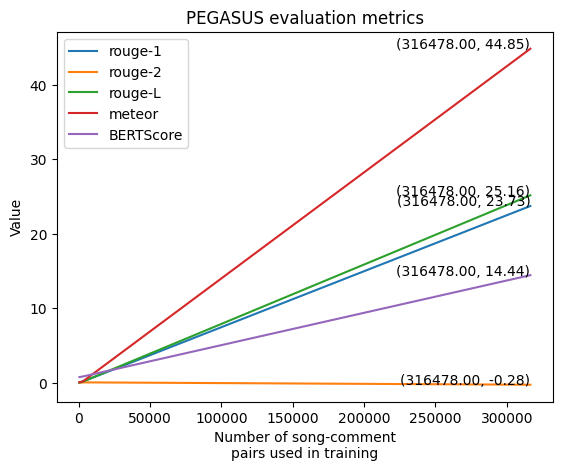

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

# positions to inter/extrapolate
xi = np.linspace(500, 316478, 50000)

# spline order: 1 linear
order = 1
# do inter/extrapolation
x = df["songs loaded"]
s = InterpolatedUnivariateSpline(x, df["p-rouge1-f"], k=order)
y_r1 = s(xi)
s = InterpolatedUnivariateSpline(x, df["p-rouge2-f"], k=order)
y_r2 = s(xi)
s = InterpolatedUnivariateSpline(x, df["p-rougeL-f"], k=order)
y_rl = s(xi)
s = InterpolatedUnivariateSpline(x, df["p-meteor"], k=order)
y_m = s(xi)
s = InterpolatedUnivariateSpline(x, df["p-BERTScore-f"], k=order)
y_bs = s(xi)

plt.plot(xi, y_r1, label = "rouge-1")
plt.annotate(f'({xi[-1]:.2f}, {y_r1[-1]:.2f})', (xi[-1], y_r1[-1]), ha='right')
plt.plot(xi, y_r2, label = "rouge-2")
plt.annotate(f'({xi[-1]:.2f}, {y_r2[-1]:.2f})', (xi[-1], y_r2[-1]), ha='right')
plt.plot(xi, y_rl, label = "rouge-L")
plt.annotate(f'({xi[-1]:.2f}, {y_rl[-1]:.2f})', (xi[-1], y_rl[-1]), ha='right')
plt.plot(xi, y_m, label = "meteor")
plt.annotate(f'({xi[-1]:.2f}, {y_m[-1]:.2f})', (xi[-1], y_m[-1]), ha='right')
plt.plot(xi, y_bs, label = "BERTScore")
plt.annotate(f'({xi[-1]:.2f}, {y_bs[-1]:.2f})', (xi[-1], y_bs[-1]), ha='right')
plt.title('PEGASUS evaluation metrics')
plt.xlabel('Number of song-comment\npairs used in training')
plt.ylabel('Value')
plt.legend()

plt.show()

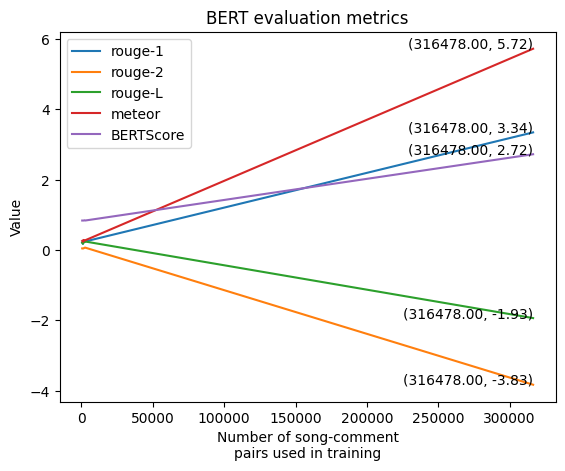

In [7]:
s = InterpolatedUnivariateSpline(x, df["b-rouge1-f"], k=order)
y_r1 = s(xi)
s = InterpolatedUnivariateSpline(x, df["b-rouge2-f"], k=order)
y_r2 = s(xi)
s = InterpolatedUnivariateSpline(x, df["b-rougeL-f"], k=order)
y_rl = s(xi)
s = InterpolatedUnivariateSpline(x, df["b-meteor"], k=order)
y_m = s(xi)
s = InterpolatedUnivariateSpline(x, df["b-BERTScore-f"], k=order)
y_bs = s(xi)

plt.plot(xi, y_r1, label = "rouge-1")
plt.annotate(f'({xi[-1]:.2f}, {y_r1[-1]:.2f})', (xi[-1], y_r1[-1]), ha='right')
plt.plot(xi, y_r2, label = "rouge-2")
plt.annotate(f'({xi[-1]:.2f}, {y_r2[-1]:.2f})', (xi[-1], y_r2[-1]), ha='right')
plt.plot(xi, y_rl, label = "rouge-L")
plt.annotate(f'({xi[-1]:.2f}, {y_rl[-1]:.2f})', (xi[-1], y_rl[-1]), ha='right')
plt.plot(xi, y_m, label = "meteor")
plt.annotate(f'({xi[-1]:.2f}, {y_m[-1]:.2f})', (xi[-1], y_m[-1]), ha='right')
plt.plot(xi, y_bs, label = "BERTScore")
plt.annotate(f'({xi[-1]:.2f}, {y_bs[-1]:.2f})', (xi[-1], y_bs[-1]), ha='right')
plt.title('BERT evaluation metrics')
plt.xlabel('Number of song-comment\npairs used in training')
plt.ylabel('Value')
plt.legend()

plt.show()

# Interact with models

In [8]:
import ipywidgets as widgets
import pickle
import random
import math
import pprint
from transformers import pipeline
from transformers import AutoTokenizer

# Dataset
with open("/content/drive/My Drive/Comp 700/datasets/clean/dataset_dict.pkl", "rb") as f: dataset = pickle.load(f)
with open("/content/drive/My Drive/Comp 700/datasets/clean/dataset_test.pkl", "rb") as f: dataset_test = pickle.load(f)

def load_sample(obj):
  x = math.floor(random.uniform(0, len(dataset[data_set.value])))
  dataset_lyrics.value = dataset[data_set.value]['lyrics'][x]
  dataset_comment.value = dataset[data_set.value]['comment'][x]

data_set = widgets.RadioButtons(
    options=['train', 'validation'],
    value='train',
    description='Set :',
    disabled=False
)
dataset_lyrics = widgets.Textarea(value='',disabled=True, layout=widgets.Layout(height="100%", width="auto"))
dataset_comment = widgets.Textarea(value='',disabled=True, layout=widgets.Layout(height="100%", width="auto"))
dataset_refresh = widgets.Button(description='Load sample', disabled=False, button_style='info', tooltip='Click me', icon='check')
dataset_refresh.on_click(load_sample)

dataset_HBox = widgets.HBox([widgets.VBox([widgets.Label("Lyrics"), dataset_lyrics]), widgets.VBox([widgets.Label("User interpretation"), dataset_comment])])
dataset_VBox = widgets.VBox([data_set, dataset_refresh, dataset_HBox])


# Tokenizer

b_tk = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
p_tk = AutoTokenizer.from_pretrained("google/pegasus-large")

def tokenize_sentence(obj):

  inputs = b_tk(tk_sen.value)
  tk_b_output.value = ""
  tk_b_output.value += "Inputs to the model would be : \n"
  tk_b_output.value += pprint.pformat(inputs, indent=4)
  tk_b_output.value += "\nConverting input_ids back into words : \n"
  tk_b_output.value += pprint.pformat(b_tk.convert_ids_to_tokens(inputs.input_ids), indent=4)

  inputs = p_tk(tk_sen.value)
  tk_p_output.value = ""
  tk_p_output.value += "Inputs to the model would be : \n"
  tk_p_output.value += pprint.pformat(inputs, indent=4)
  tk_p_output.value += "\nConverting input_ids back into words : \n"
  tk_p_output.value += pprint.pformat(p_tk.convert_ids_to_tokens(inputs.input_ids), indent=4)

tk_sen = widgets.Text(value='I love comp sci!',disabled=False)
tokenizer_button = widgets.Button(description='Tokenize sentence', disabled=False, button_style='warning', tooltip='Click me', icon='check')
tokenizer_button.on_click(tokenize_sentence)
tk_p_output = widgets.Textarea(value='', placeholder='PEGASUS tokenization',disabled=True)
tk_b_output = widgets.Textarea(value='', placeholder='BERT tokenization',disabled=True)
tk_b_output_box = widgets.VBox([widgets.Label("BERT tokenizer"), tk_b_output])
tk_p_output_box = widgets.VBox([widgets.Label("PEGASUS tokenizer"), tk_p_output])

tk_output_box = widgets.HBox([tk_b_output_box, tk_p_output_box])
tk_VBox = widgets.VBox([widgets.Label("Enter sentence to tokenize"), tk_sen, tokenizer_button, tk_output_box])


# Model

def load_model_checkpoint(obj):
  global interpreter
  interpreter  = pipeline("summarization", model=model_sample_checkpoint.value)

def load_prediction(obj):
  x = math.floor(random.uniform(0, len(dataset_test['test'])))
  model_sample_lyrics_out.value = dataset_test['test']['lyrics'][x]
  model_sample_comment_out.value = dataset_test['test']['comment'][x]
  s = interpreter(dataset_test['test']['lyrics'][x])
  model_sample_pred_out.value = s[0]["summary_text"]

def own_prediction(obj):
  s = interpreter(model_own_lyrics_out.value)
  model_own_pred_out.value = s[0]["summary_text"]


model_sample_lyrics_out = widgets.Textarea(value='',disabled=True, layout=widgets.Layout(height="100%", width="auto"))
model_sample_lyrics = widgets.VBox([widgets.Label("Lyrics"), model_sample_lyrics_out])
model_sample_comment_out = widgets.Textarea(value='',disabled=True, layout=widgets.Layout(height="100%", width="auto"))
model_sample_comment = widgets.VBox([widgets.Label("Interpretation"), model_sample_comment_out])
model_sample_pred_out = widgets.Textarea(value='',disabled=True, layout=widgets.Layout(height="100%", width="auto"))
model_sample_pred = widgets.VBox([widgets.Label("Prediction"), model_sample_pred_out])

model_sample_checkpoint = widgets.Dropdown(
    options=[
        ('BERT (trained on 500 songs)', "s-man2099/fblc-500"), ('BERT (1000)', "s-man2099/fblc-1000"), ('BERT (1500)', "s-man2099/fblc-1500"),
       ('BERT (2000)', "s-man2099/fblc-2000"), ('BERT (2500)', "s-man2099/fblc-2500"), ('BERT (3000)', "s-man2099/fblc-3000"),
        ('PEGASUS (trained on 500 songs)', "s-man2099/gpl-500"), ('PEGASUS (1000)', "s-man2099/gpl-1000"), ('PEGASUS (1500)', "s-man2099/gpl-1500"),
       ('PEGASUS (2000)', "s-man2099/gpl-2000"), ('PEGASUS (2500)', "s-man2099/gpl-2500"), ('PEGASUS (3000)', "s-man2099/gpl-3000")
      ],
    value="s-man2099/gpl-3000"
)
model_sample_load_checkpoint = widgets.Button(description='Load', disabled=False, button_style='danger', tooltip='Loads specified model checkpoint', icon='check')
model_sample_load_checkpoint.on_click(load_model_checkpoint)

model_sample_predict = widgets.Button(description='Interpret', disabled=False, button_style='danger', tooltip='Loads song from test set and outputs an interpretation (it may take a while)', icon='check')
model_sample_predict.on_click(load_prediction)

model_sample_HBox = widgets.HBox([model_sample_lyrics, model_sample_comment, model_sample_pred])
model_sample_checkpoint_HBox = widgets.HBox([widgets.Label("Enter model checkpoint"), model_sample_checkpoint, model_sample_load_checkpoint])
model_sample_VBox = widgets.VBox([model_sample_checkpoint_HBox, model_sample_predict, model_sample_HBox])

model_own_lyrics_out = widgets.Textarea(value='',disabled=False, layout=widgets.Layout(height="100%", width="auto"))
model_own_lyrics = widgets.VBox([widgets.Label("Enter your own lyrics"), model_own_lyrics_out])
model_own_pred_out = widgets.Textarea(value='',disabled=True, layout=widgets.Layout(height="100%", width="auto"))
model_own_pred = widgets.VBox([widgets.Label("Prediction"), model_own_pred_out])

model_own_predict = widgets.Button(description='Interpret', disabled=False, button_style='danger', tooltip='Load your own song (please load a model checkpoint first)', icon='check')
model_own_predict.on_click(own_prediction)

model_own_HBox = widgets.HBox([model_own_lyrics, model_own_pred])
model_own_VBox = widgets.HBox([model_own_HBox, model_own_predict])

# There is a small title issue here, but you can click the rectangles to expand the relevant sections
model_accordion = widgets.Accordion(children=[model_sample_VBox, model_own_VBox], titles=('Predict songs in test dataset', 'Use your own song'))

names = ['Dataset', 'Tokenizer', 'Model']
children = [dataset_VBox, tk_VBox, model_accordion]
tab = widgets.Tab()
tab.children = children
[tab.set_title(i, title) for i, title in enumerate(names)]
tab

NameError: ignored

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at s-man2099/fblc-3000.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
